# Social Physics Project: Facebook 1 

## Modules

In [1]:
# Enable interactive numpy and matplotlib
%pylab inline

# Data Wrangling 
import pandas as pd
import numpy as np

# Data Analysis
import powerlaw as pwl

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker

# Network Analysis 
import networkx as nx
from networkx.algorithms import community
import networkx.algorithms.centrality as nc
import social_physics as soc

# Network Epidemiology 
import EoN

# Data Visualization
import seaborn as sns
from netwulf import visualize

# Other Utilities 
import sys, os, os.path
import itertools
from progressbar import ProgressBar, Bar, Percentage
from operator import itemgetter
from collections import Counter
from collections import defaultdict
import random

# Reload Custom Modules
from importlib import reload
soc = reload(soc)

Populating the interactive namespace from numpy and matplotlib


## Data Collection

In [2]:
# Import graphml file 

G = nx.Graph( nx.read_graphml("/Users/pietromonticone/github/SocialPhysics/inphyt-project/Data/Gephi/Facebook1.graphml") )

### pietro's path r"/Users/pietromonticone/github/SocialPhysics/inphyt-project/Gephi/pietro_first_order.graphml"
### claudio's path r"Q:\IlMIoDrive\magistrale\1anno\terzo_periodo\CSS\progetto\outputs\graphs\pietro_first_order.graphml"

# Rename the graph 
G.name = "Facebook Friend EgoGraph"

# Show the basic attributes of the graph
print(nx.info(G))

# Relable the nodes (from strings of Twitter IDs to integers)
G = nx.convert_node_labels_to_integers(G, first_label=0, ordering='default', label_attribute=None)

Name: Facebook Friend EgoGraph
Type: Graph
Number of nodes: 2687
Number of edges: 16145
Average degree:  12.0171


## Graph Visualization 

```python 
visualize(G)
```

![](Images/@DavideOrsenigo1.png)

## Degree Distributions

### Degree Distribution 

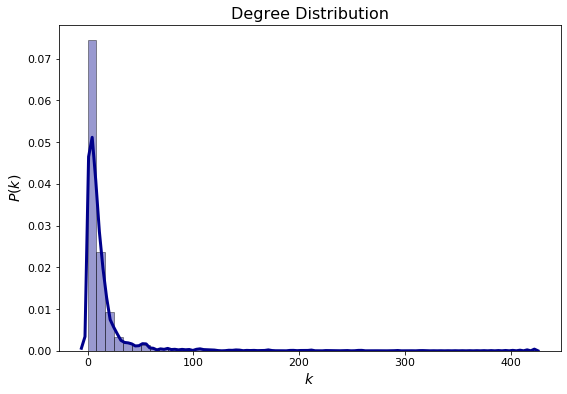

Mean =  624.7581736154269 
Var =  12.017119464086342


In [3]:
# ORGANIZE IN SUBPLOTS!

# Get undirected degree distribution 
undirected_degree_distribution, degree_mean, degree_variance = soc.get_degree_distribution(G, "degree")

# Set figure size
plt.figure(figsize=(9,6))

# Plot undirected degree distribution 
soc.plot_degree_distribution(undirected_degree_distribution, 
                             title = "Degree Distribution", 
                             log = False, 
                             display_stats = True)

# Show mean and variance of the undirected degree distribution 
print("Mean = ", degree_mean,"\nVar = ", degree_variance)

In [4]:
# degree = dict(G.degree()).values()
# degree_distribution = Counter(degree)

# # Degree distribution
# x=[]
# y=[]
# for i in sorted(degree_distribution):   
#     x.append(i)
#     y.append(degree_distribution[i]/len(G))

# plt.figure(figsize=(10,7))    
# plt.plot(x,y, "o-")

# plt.xlabel('$k$', fontsize=18)
# plt.ylabel('$P(k)$', fontsize=18)

# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)

# #plt.yscale('log')
# #plt.xscale('log')
# #plt.axis([1,1000,0.0001,1])
# plt.show()

# # Interpolation
# plt.figure(figsize=(10,7))
# plt.hist(degree, bins=500, density=True, log=False, histtype='stepfilled')
# plt.plot(x,y,'black','o')
# #plt.xscale('log')
# #plt.yscale('log')
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=22)
# plt.xlabel('$k$', fontsize=22)
# # plt.ylabel('$P(k)$', fontsize=22)

### Logarithmic Binning

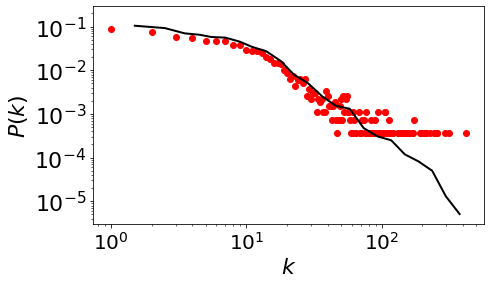

In [5]:
# Set figure size
plt.figure(figsize=(7,4))

# Plot
pwl_distribution = soc.power_law_plot(graph = G, log = True,linear_binning = False, bins = 900000, draw = True)

### Linear Binning

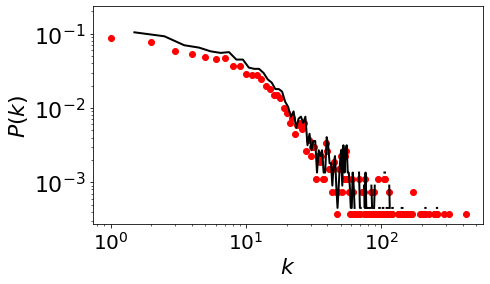

In [6]:
# Set figure size
plt.figure(figsize=(7,4))

# Plot 
pwl_distribution = soc.power_law_plot(graph = G, log = True,linear_binning = True, bins = 90, draw = True)

### Power Law Fitting 

#### Parameters Estimation

In [7]:
fit_function = pwl.Fit(list(undirected_degree_distribution.values())) # problem here 
#print(sort(list(undirected_degree_distribution.values()))[-1])

print("Exponent = ", fit_function.power_law.alpha)
print("Sigma (error associated to exponent) = ",fit_function.power_law.sigma)
xmin = fit_function.power_law.xmin
print("x_min = ",xmin)
print("Kolmogorov-Smirnov distance = ",fit_function.power_law.D)

Exponent =  2.4013357367748545
Sigma (error associated to exponent) =  0.048670401871054
x_min =  11.0
Kolmogorov-Smirnov distance =  0.029318081157500675


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/Users/pietromonticone/opt/anaconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


Because the fitted $x_{min} = 224$, let's require it to be a little higher prior to fitting

In [8]:
fit_function_fix_xmin = pwl.Fit(list(undirected_degree_distribution.values()),xmin= 20) 
print("Exponent = ", fit_function_fix_xmin.power_law.alpha)
print("Sigma (error associated to exponent) = ",fit_function_fix_xmin.power_law.sigma)
print("x_min = ",fit_function_fix_xmin.power_law.xmin)
print("Kolmogorov-Smirnov distance = ",fit_function_fix_xmin.power_law.D)

Exponent =  2.3989779931693223
Sigma (error associated to exponent) =  0.07312575113568848
x_min =  20.0
Kolmogorov-Smirnov distance =  0.05795049118008577


Values less than or equal to 0 in data. Throwing out 0 or negative values


Now the error (sigma) is way lower than before, but Kolmogorov-Smironv is higher as expected (because we fixed $x_min$ prior to fitting). Thus we confirmed that a power law fitting is good only near the tail.<br>
Let us now compare the actual pdf with the fitted power law near the tail.<br>
<span style="color:blue">BLUE</span> : Fitted power law <br>
<span style="color:black">BLACK</span> : plotted pdf

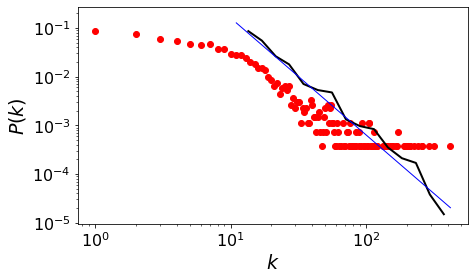

In [9]:
# Set figure size
plt.figure(figsize=(7,4))

pwl_distribution = soc.power_law_plot(graph = G, log = True, linear_binning = False, bins = 90, draw = True, x_min = xmin)

fit_function.power_law.plot_pdf(color='b', linestyle='-', linewidth=1)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('$k$', fontsize=19)
plt.ylabel('$P(k)$', fontsize=19)
plt.show()

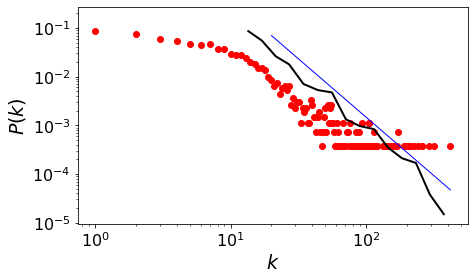

In [10]:
# Set figure size
plt.figure(figsize=(7,4))

#plt.plot(x,y,'ro')

pwl_distribution = soc.power_law_plot(graph = G, log = True,linear_binning = False, bins = 90, draw = True, x_min = xmin)

fit_function_fix_xmin.power_law.plot_pdf(color='b', linestyle='-', linewidth=1)

#fig.legend(fontsize=22)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('$k$', fontsize=19)
plt.ylabel('$P(k)$', fontsize=19)
plt.show()

Let us now compare power law against other probability distributions

In [11]:
R,p = fit_function.distribution_compare('power_law', 'exponential', normalized_ratio=True) 
R,p

/Users/pietromonticone/opt/anaconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


(7.245579172152439, 4.305951554443543e-13)

In [12]:
R,p = fit_function.distribution_compare('power_law', 'lognormal_positive', normalized_ratio=True)
R,p

(1.639922812093965, 0.10102121704256116)

In [13]:
R,p = fit_function.distribution_compare('power_law', 'truncated_power_law', normalized_ratio=True)
R,p

Assuming nested distributions


(-1.9292355287624405, 0.03107012418341748)

In [14]:
R,p = fit_function.distribution_compare('power_law', 'stretched_exponential', normalized_ratio=True)
R,p

(0.6039320392827594, 0.54588882653211)

Let us also compare with the truncated power law:

In [15]:
R,p = fit_function_fix_xmin.distribution_compare('power_law', 'exponential', normalized_ratio=True) 
R,p

(3.35026508382357, 0.0008073425751459756)

In [16]:
R,p = fit_function_fix_xmin.distribution_compare('power_law', 'lognormal_positive', normalized_ratio=True) 
R,p

(-1.4595210469053803, 0.14442175211427194)

In [17]:
R,p = fit_function_fix_xmin.distribution_compare('power_law', 'stretched_exponential', normalized_ratio=True) 
R,p

(-1.5397110317429374, 0.12363080657660151)

## Centrality Metrics 

#### Degree

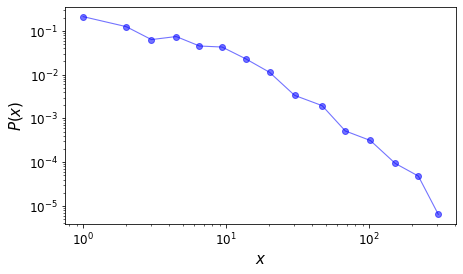

In [18]:
# Get degree centrality 
degree_centrality = soc.get_centrality(G, "degree")

# Set figure size
plt.figure(figsize=(7,4))

# Plot centrality distribution
soc.plot_centrality_distribution(G, degree_centrality, "Blue", 15)

#### Closeness

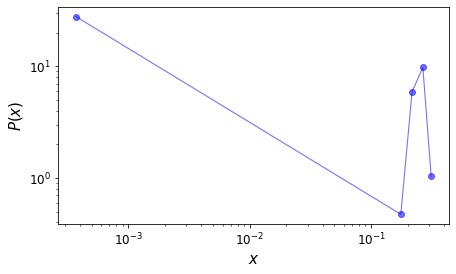

In [19]:
# Get closeness centrality (computationally intensive!)
closeness_centrality = soc.get_centrality(G, "closeness")

# Set figure size
plt.figure(figsize=(7,4))

# Plot centrality distribution
soc.plot_centrality_distribution(G, closeness_centrality, "Blue", 30)

#### Bewteenness

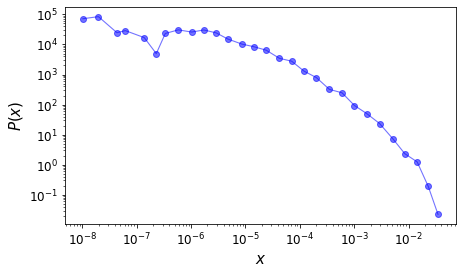

In [20]:
# Get degree centrality 
betweenness_centrality = soc.get_centrality(G, "betweenness")

# Set figure size
plt.figure(figsize=(7,4))

# Plot centrality distribution
soc.plot_centrality_distribution(G, betweenness_centrality, "Blue", 30)

#### Katz

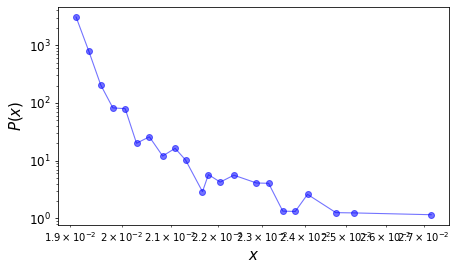

In [21]:
# Get degree centrality 
katz_centrality = soc.get_centrality(G, "katz")

# Set figure size
plt.figure(figsize=(7,4))

# Plot centrality distribution
soc.plot_centrality_distribution(G, katz_centrality, "Blue", 30)

#### Eigenvector 

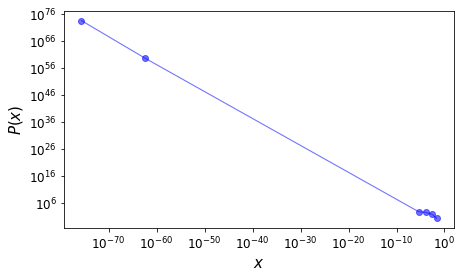

In [22]:
# Get degree centrality 
eigenvector_centrality = soc.get_centrality(G, "eigenvector")

# Set figure size
plt.figure(figsize=(7,4))

# Plot centrality distribution
soc.plot_centrality_distribution(G, eigenvector_centrality, "Blue", 50)

#### PageRank
$$x=\frac{1-\alpha}{N}+ \alpha \sum_{j}A^{T}_{ij}\frac{x_j}{k^{out}_j}+\frac{\alpha}{N}\sum_{j|k^{out}_j=0}x_j$$

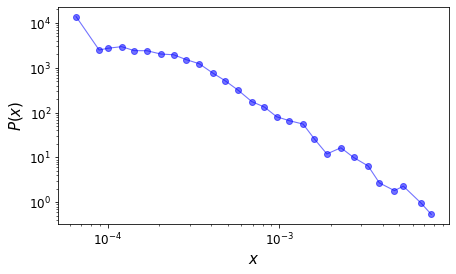

In [23]:
# Get degree centrality 
pagerank_centrality = soc.get_centrality(G, "pagerank")

# Set figure size
plt.figure(figsize=(7,4))

# Plot centrality distribution
soc.plot_centrality_distribution(G, pagerank_centrality, "Blue", 30)

## Connectivity 

In [24]:
# Show the connectivity of the analyzed graph
print("The graph has", G.number_of_nodes(), "nodes and", G.number_of_edges(),"edges.")
#print("Is the (directed) graph weakly connected?", nx.is_weakly_connected(G))  # https://en.wikipedia.org/wiki/Directed_graph#Directed_graph_connectivity
#print("Is the (directed) graph strongly connected?", nx.is_strongly_connected(G))
print("Is the graph connected?", nx.is_connected(G),".")
print("The graph has", nx.number_connected_components(G),"connected components.")
#print("The graph has", nx.number_weakly_connected_components(G),"weakly connected components")
#print("The graph has", nx.number_strongly_connected_components(G),"strongly connected components")

The graph has 2687 nodes and 16145 edges.
Is the graph connected? False .
The graph has 466 connected components.


## Clustering 

### Global clustering coefficient

The global clustering coefficient measures the number of triangles in the network and it's defined as

$$ C_\Delta = \frac{3 \times \text{triangles}}{\text{triplets}} $$

In order to compare our graph with theorical models (of the same size), it is thus sufficient to evaluate the number of triangles

In [25]:
# Create a dictionary of triangles such that 
## keys = nodes
## values = number of triangles the key belongs to
triangles = nx.triangles(G)

# How many triangles are there in the whole network? dividi pr 3 poichè ogni nodo è contato tre volte
number_triangles = sum(list(triangles.values())) / 3 #1350014
print("number_triangles = ",number_triangles)
# Compute the transitivity of H: the fraction of all possible triangles in the network.
print("transitivity = ", nx.transitivity(G))

number_triangles =  18813.0
transitivity =  0.05548280926512484


### Average clustering coefficient

The overall level of clustering in a network is measured by Watts and Strogatz as the average of the local clustering coefficients of all the vertices $n$:

$$\bar{C} = \frac{1}{n}\sum_{i=1}^{n} C_i.$$


It is worth noting that this metric places more weight on the low degree nodes, while the transitivity ratio places more weight on the high degree nodes. In fact, a weighted average where each local clustering score is weighted by $k_i(k_i-1)$ is identical to the global clustering coefficient.

In [26]:
print("The average clustering coefficient is ", nx.average_clustering(G)) # note: as per https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.cluster.clustering.html and https://networkx.github.io/documentation/stable/_modules/networkx/algorithms/cluster.html , thos function cares about the graph being directed or not

The average clustering coefficient is  0.1535702800968082


## Path-ology  

### Average shortest path length

In [27]:
#print("The average shortest path length is ", nx.average_shortest_path_length(G)) # Graph is not weakly connected.

# Is G small world? 
# Does the average shortest path length scale with log_10(|G|)

### Warning! Calculating the shortest paths is computationally intensive !
#print("The average shortest path length is", nx.average_shortest_path_length(UD_G), 
#      ", while the log_10(|UD_G|) =", math.log(len(G), 10))

### Comparisons

#### G vs. ER

The most natural benchmark is a ER (random) network with the same number of nodes and links. In a ER netork, the p_k is poissonian ( an exponential decay) , so let's compare G with random **Erdos-Renyi** graph with the same average connectivity and number of nodes.

In [28]:
nnodes = G.number_of_nodes()
nedges = G.number_of_edges()
#plink = 0.07803
plink = 2*nedges/(nnodes*(nnodes-1)) #2* because it is undirected

ER = nx.fast_gnp_random_graph(nnodes, plink)

# Test connectedness
print("Is the ER graph simply connected ?", nx.is_connected(ER))

# Connectivity
print("The ER graph has", len(ER), "nodes", "and",len(ER.edges()),"edges .")

# Average clustering coefficient
print("The average clustering coefficient of ER is", nx.average_clustering(ER))

# Total number of triangles (it was here since it was present in tizzon's notebook Its presence on the latter is justified by t eh fact that this number is proportioank to th eglobal clusetring coefficient, whcih is not defined for directed graphs. thus it is useless here)(later we tried to make an undirected graph from the directed one, so we reused it)
print("The total number of triangles in the network is", sum(list(nx.triangles(ER).values()))/3)

# Average shortest path
#print("The ER graph is small world since the average shortest path is", nx.average_shortest_path_length(ER), 
#      "and the log of the nodal cardinality is", math.log(len(ER), 10))

Is the ER graph simply connected ? True
The ER graph has 2687 nodes and 16294 edges .
The average clustering coefficient of ER is 0.0043115109145566615
The total number of triangles in the network is 288.0


#### G vs. AB

Thinking about  a broad (not exponential decaying) distribution, more like a power law, we may think about a AB network (albert-barabasi), so let's compare G with random **Albert-Barabasi** graph with the same average connectivity and number of nodes. 

In [29]:
n = G.number_of_nodes()
m = int(G.number_of_edges() / G.number_of_nodes()) 

AB = nx.barabasi_albert_graph(n,m)

# Test connectedness
print("Is the AB graph simply connected ?", nx.is_connected(AB))
# Connectivity
print("The AB graph has", len(AB), "nodes", "and",len(AB.edges()),"edges .")

# Average clustering coefficient
print("The average clustering coefficient of AB is", nx.average_clustering(AB))

# Total number of triangles (it was here since it was present in tizzon's notebook Its presence on the latter is justified by the fact that this number is proportioank to th eglobal clusetring coefficient, whcih is not defined for directed graphs. thus it is useless here) (later we tried to make an undirected graph from the directed one, so we reused it)
print("The total number of triangles in the network is", sum(list(nx.triangles(AB).values()))/3)

# Average shortest path
##print("The AB graph is small world since the average shortest path is", nx.average_shortest_path_length(AB), 
##      "and the log of the nodal cardinality is", math.log(len(AB), 10))

Is the AB graph simply connected ? True
The AB graph has 2687 nodes and 16086 edges .
The average clustering coefficient of AB is 0.02425635461611711
The total number of triangles in the network is 2615.0


Let's verify that an AB network follows a power law distribution

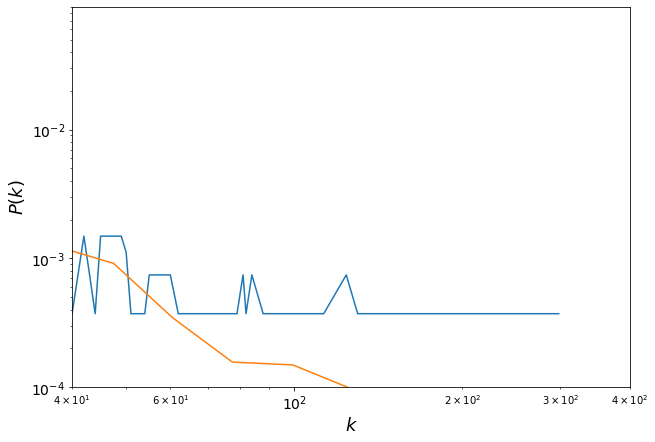

alpha =  3.0180042399464506
sigma =  0.06921697439248004
x_min =  11.0
Kolmogorov-Smirnov distance =  0.03468171224870198


/Users/pietromonticone/opt/anaconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


In [30]:
# Create the degree distribution
AB_degree = dict(AB.degree()).values()
AB_degree_distribution = Counter(AB_degree)

# Plot the degree frequency distribution & 
# the probability density function 
plt.figure(figsize=(10,7))
x=[]
y=[]
for i in sorted(AB_degree_distribution):   
    x.append(i)
    y.append(float(AB_degree_distribution[i])/len(AB))

plt.plot(np.array(x),np.array(y))
pwl.plot_pdf(list(AB_degree))

plt.xlabel('$k$', fontsize=18)
plt.ylabel('$P(k)$', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.xscale('log')
plt.axis([40,400,0.0001,0.09])
plt.show()

# Fit the degree distribution with a power law
fit_function = pwl.Fit(list(AB_degree), xmin=11)

# Output parameters
print("alpha = ",fit_function.power_law.alpha)
print("sigma = ",fit_function.power_law.sigma)
print("x_min = ", fit_function.power_law.xmin)
print("Kolmogorov-Smirnov distance = ",fit_function.power_law.D)

#### G vs. WS
Watts stogatz netowrk combines small world (short average shortest path) with high clustering coefficient. This model starts from a reticule where each node is connected to its $d$ nearest neighbors,. and then with probability $r = 0.2$ each link is detached from one end and reformed with another random node.
Let's compare G with random **Watts-Strogatz** graph with the same average connectivity and number of nodes.<br>

In [31]:
# Input parameters
n = G.number_of_nodes() # nodal cardinality
d = 71 #93 # average degree
r = 0.2 # rewiring rate
runs = 50

WS = nx.connected_watts_strogatz_graph(n, d, r, runs)

# Test connectedness
print("Is the WS graph simply connected ?", nx.is_connected(WS))

# Connectivity
print("The WS graph has", len(WS), "nodes", "and",len(WS.edges()),"edges .") # 1177 nodes, 54166 edges

# Average clustering coefficient
print("The average clustering coefficient of WS is", nx.average_clustering(WS))

# Total number of triangles 
print("The total number of triangles in the network is", sum(list(nx.triangles(WS).values()))/3)

# Average shortest path
##print("The WS graph is small world since the average shortest path is", nx.average_shortest_path_length(WS), 
##      "and the log of the nodal cardinality is", math.log(len(WS), 10))

Is the WS graph simply connected ? True
The WS graph has 2687 nodes and 94045 edges .
The average clustering coefficient of WS is 0.38624672450070496
The total number of triangles in the network is 834122.0


(array([  0., 100., 200., 300., 400., 500., 600., 700.]),
 <a list of 8 Text yticklabel objects>)

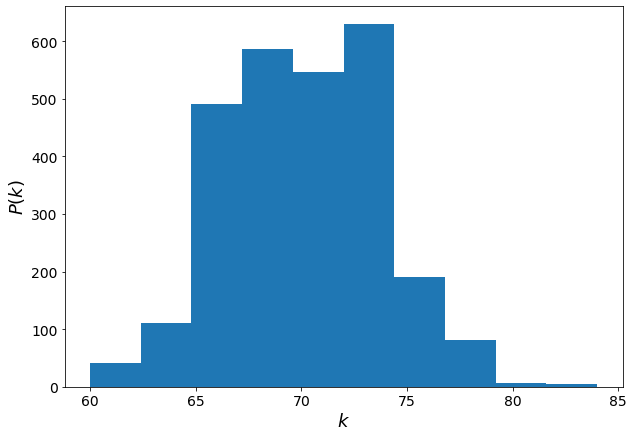

In [32]:
# Extract the degree distribution 
ws_degrees = (dict(WS.degree()).values())

# Plot the degree frequency distribution
plt.figure(figsize=(10,7))
plt.hist(ws_degrees, bins=10)
plt.xlabel('$k$', fontsize=18)
plt.ylabel('$P(k)$', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

## Closeness Centrality

In connected graphs there is a natural distance metric between all pairs of nodes, defined by the length of their shortest paths. 
The '''farness''' of a node ''x'' is defined as the sum of its distances from all other nodes, and its closeness was defined by Bavelas as the reciprocal of the farness that is:


<center>
$C(x)= \frac{1}{\sum_y d(y,x)}.$
</center>


Thus, the more central a node is the lower its total distance from all other nodes. Note that taking distances ''from'' or ''to'' all other nodes is irrelevant in undirected graphs, whereas in directed graphs distances ''to'' a node are considered a more meaningful measure of centrality, as in general (e.g., in, the web) a node has little control over its incoming links.


In [33]:
# Choose a node x 
#x = 

# Compute its closeness centrality 
### Computing all the distances between pair of nodes can be intensive !
#print("The closeness centrality of the node", x, "is", nx.closeness_centrality(G, x))

# Degree assortativity of a network

A network is assortative with respect to a feature/features if nodes with similar feature(s) values are more often connected between them rather then with nodes having different feature(s) values.<br>
The degree assortativity is assortativity with respect to degree: are nodes with similar degree more connected between themselves than with nodes with different degree?<br>
Degree assortativity can be measured in different ways. A simple approach is measuring the average nearest neighbor degree to assess the level of degree-assortativity.

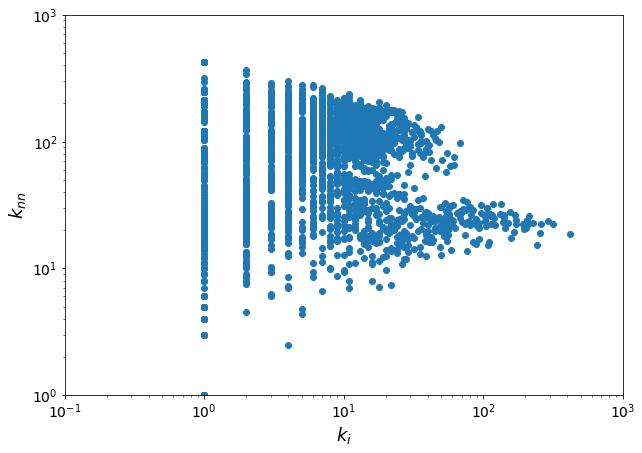

<class 'list'> (0, 0)


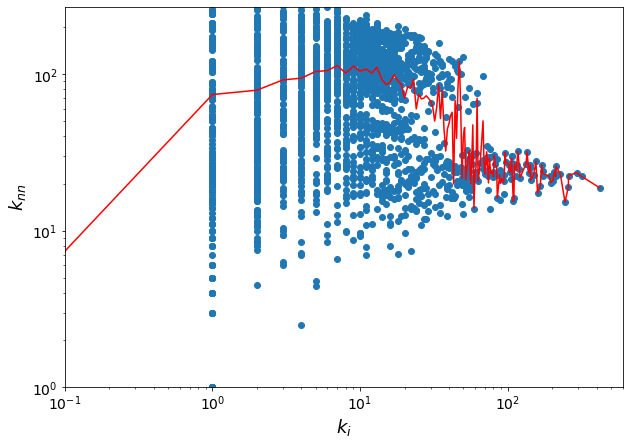

In [34]:
# Compute the average nearest neighbour degree for all the nodes in G 
x=[]
y=[]

avg_knn = defaultdict(list)

# so for every node n, extract its degree k and append to the value of the defaultdict avg_knn corresponding to the key k the average degree of the neighbours of that node. SO avg_knn becomes a dict of the type {k:[ak_1,ak_2,..]} where ak_i is the average degree of the neighbours of  the i-th node with degree k. Also save the k's in x and the average degrees of neighbours in y
for n in G.nodes():
    
    #k=soc.omit_by(dct = dict(G.degree()))
    k = G.degree(n)
    #nn=len(G.neighbors(n))
    total=0
    if k != 0:
        for j in G.neighbors(n):
            total+=G.degree(j)

        avg_knn[k].append(float(total)/k)
        x.append(k)
        y.append(float(total)/k)
    else:
        avg_knn[k].append(0)
        x.append(k)
        y.append(0)
    
#     x.append(k)
#     y.append(float(total)/k)

# Plot the average nearest neighbour degree vs. individual degree
plt.figure(figsize=(10,7))
plt.scatter(x,y)

plt.xlabel('$k_i$', fontsize=18)
plt.ylabel('$k_{nn}$', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.xscale('log')
plt.axis([0.1,1000,1,1000])
plt.show()

# Plot the average degree connectivity vs. individual degree


knn_avg4_items = nx.average_degree_connectivity(G).items()
knn_avg4 = sorted(knn_avg4_items)
print(type(knn_avg4),knn_avg4[0])
z = [t[1] for t in knn_avg4]

plt.figure(figsize=(10,7))
plt.scatter(x,y)
plt.plot(sorted(avg_knn.keys()), z,'r-')
#plt.plot(sorted(avg_knn.keys()), z1,'g-')

plt.xlabel('$k_i$', fontsize=18)
plt.ylabel('$k_{nn}$', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.xscale('log')
# plt.axis([0.1,1000,1,1000])
plt.axis([0.1,600,1,270])
plt.show()

In [35]:
# degree assortativity can also be computed with nx's functions
# Compute the degree assortativity coefficient of G and ER
dac_G = nx.degree_assortativity_coefficient(G) # this is the pearson correlation coefficient of the red dots of the plot above. Infact, for the ER network it is close to zero, since in a ER network nodes are likely to connect regardless of their degree.
dac_ER = nx.degree_assortativity_coefficient(ER)
dac_AB = nx.degree_assortativity_coefficient(AB)
dac_WS = nx.degree_assortativity_coefficient(WS)

print("The degree assortativity coefficient of G is", dac_G, 
      "\nwhile the degree assortativity coeffiecient of a ER graph is", dac_ER,
      "\nwhile the degree assortativity coeffiecient of a AB graph is" ,dac_AB,
      "\nwhile the degree assortativity coeffiecient of a WS graph is" ,dac_WS,)

# Compute the Pearson / linear correlation coefficient with nx function
pcc_G = nx.degree_pearson_correlation_coefficient(G)
pcc_ER = nx.degree_pearson_correlation_coefficient(ER)
pcc_AB = nx.degree_pearson_correlation_coefficient(AB)
pcc_WS = nx.degree_pearson_correlation_coefficient(WS)

print("The Pearson correlation coefficient of G is", pcc_G, 
      "\nwhile the Pearson correlation coeffiecient of a ER graph is", pcc_ER,
      "\nwhile the Pearson correlation coeffiecient of a AB graph is" ,pcc_AB,
      "\nwhile the Pearson correlation coeffiecient of a WS graph is" ,pcc_WS,)

The degree assortativity coefficient of G is -0.30490922412347915 
while the degree assortativity coeffiecient of a ER graph is -0.0014397528731713671 
while the degree assortativity coeffiecient of a AB graph is -0.04244038613235852 
while the degree assortativity coeffiecient of a WS graph is -0.008030391157162831
The Pearson correlation coefficient of G is -0.30490922412347854 
while the Pearson correlation coeffiecient of a ER graph is -0.0014397528731697486 
while the Pearson correlation coeffiecient of a AB graph is -0.04244038613235886 
while the Pearson correlation coeffiecient of a WS graph is -0.008030391157102842


In [36]:
# rank_nodes = list of nodes to remove (one by one, progressively)
# returns a list of tuples ( number of removed nodes, size of gcc) where gcc is the giant connected component at that moment. The decay of the size of gcc is a measure of the robustness of the network, and/or ogf the efficiency of the attack. If importnat nodes are removed, size of gcc willl dcrease rapidly, while if less important nodes are removed, gcc size will decrease with the number of (less important) nodes removed.
def net_attack(graph, ranked_nodes):
    
    fraction_removed=[]#here we store the tuples: (%removed nodes, size of gcc)
    
    # make a copy of the graph to attack
    graph1=graph.copy()
    
    nnodes=len(ranked_nodes)
    n=0    
    
    gcc=list(nx.connected_components(graph1))[0] 
    
    gcc_size=float(len(gcc))/nnodes
    print("gcc_size = ", gcc_size)
    fraction_removed.append( (float(n)/nnodes, gcc_size) )
    
    while gcc_size>0.01:
        
        #we start from the end of the list!
        graph1.remove_node(ranked_nodes.pop())

        gcc=list(nx.connected_components(graph1))[0]
        gcc_size=float(len(gcc))/nnodes
        n+=1
        fraction_removed.append( (float(n)/nnodes, gcc_size) )
    
    return fraction_removed

In [37]:
# the attck sequence is the list of the airports in no particular order
airport_nodes=list(G.nodes())
resilience_random=net_attack(G, airport_nodes)


airport_nodes_betw=[]

betw=nx.betweenness_centrality(G)
for i in sorted(betw.items(), key=itemgetter(1)):
    airport_nodes_betw.append(i[0])

resilience_betw=net_attack(G, airport_nodes_betw)


airport_nodes_degree=[]

deg=dict(G.degree())
for i in sorted(deg.items(), key=itemgetter(1)):
    airport_nodes_degree.append(i[0])

resilience_deg=net_attack(G, list(airport_nodes_degree))



gcc_size =  0.0003721622627465575
gcc_size =  0.0003721622627465575
gcc_size =  0.0003721622627465575


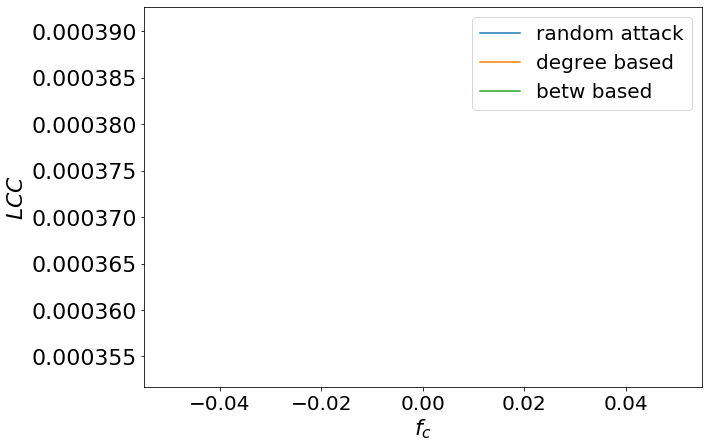

In [38]:
x=[k[0] for k in resilience_random]
y=[k[1] for k in resilience_random]

x1=[k[0] for k in resilience_deg]
y1=[k[1] for k in resilience_deg]

x2=[k[0] for k in resilience_betw]
y2=[k[1] for k in resilience_betw]

plt.figure(figsize=(10,7))

plt.plot(x,y, label='random attack')
plt.plot(x1,y1, label='degree based')
plt.plot(x2,y2, label='betw based')

plt.xlabel('$f_{c}$', fontsize=22)
plt.ylabel('$LCC$', fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=22)

plt.legend(loc='upper right', fontsize=20)
# y-axis is the size of the largest connected component, normalized wit hthe initial gcc's size. x-axis is treh fraction of nodses removed. note that degree or betweennes-based attacks are more effective than random attack. thus a network with a broad p_k is very weak against degree/betweeness attacks

## Stochastic SIR Epidemic on Static Network

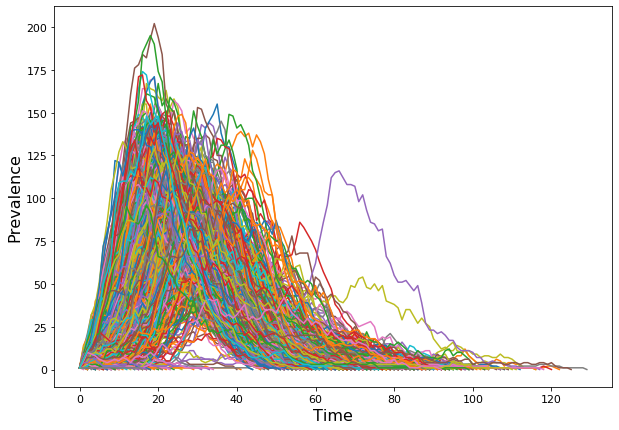

In [39]:
# Model Parameters
mu = 0.2           # Recovery rate 
lambd = 0.01       # Transmission rate per contact

# Simulation Parameters
nrun = 700       # Number of runs

# Multi-Run Simulation
runs = soc.network_SIR_multirun_simulation(G, nrun = nrun, lambd = lambd, mu = mu)

# Set figure size 
plt.figure(figsize=(10,7))

# Plot the ensemble of trajectories
soc.plot_ensemble(runs)

### $\lambda$-Sensitivity of Final Epidemic Size

In [40]:
# Perform lambda-sensitivity analysis of final epidemic size (normalized attack rate) 
data = soc.network_SIR_finalsize_lambda_sensitivity(G, mu = mu, rho = 0.05 # rho = initial fraction infected
                                                    lambda_min = 0.0001, lambda_max = 1.0, 
                                                    nruns = 20)
# Show sensitivity dataset
data 

# Set figure size 
plt.figure(figsize=(10,7))

# Display a boxplot with final epidemic size vs. transmission rate per edge/contact
soc.boxplot_finalsize_lambda_sensitivity(G, mu = mu, data = data, 
                                         ymin = 0.045, ymax= 1.1,
                                         xlim = (0.00007, 1.5) )

SyntaxError: invalid syntax (<ipython-input-40-52a51c57a819>, line 3)